In [ ]:
!git clone https://github.com/fruits-360/fruits-360-100x100.git

#List folders
!ls fruits-360-100x100

Cloning into 'fruits-360-100x100'...
remote: Enumerating objects: 141164, done.
remote: Counting objects: 100% (7024/7024), done.
remote: Compressing objects: 100% (6998/6998), done.
remote: Total 141164 (delta 38), reused 7011 (delta 26), pack-reused 134140 (from 3)
Receiving objects: 100% (141164/141164), 1018.33 MiB | 15.59 MiB/s, done.
Resolving deltas: 100% (241/241), done.
Updating files: 100% (139322/139322), done.
LICENSE  README.md  Test  Training


In [ ]:
import os

# Paths to the dataset (adjust if folder name differs after cloning)
train_dir = "/content/fruits-360-100x100/Training"
test_dir = "/content/fruits-360-100x100/Test"

# Get class names
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print("Example classes:", class_names[:10])


Number of classes: 207
Example classes: ['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 18', 'Apple 19', 'Apple 5', 'Apple 6']


In [ ]:
import shutil

# Keywords to search for in class names
keywords = ["Apple", "Banana", "Orange"]

# Filter classes dynamically based on keywords
selected_classes = [cls for cls in class_names if any(kw.lower() in cls.lower() for kw in keywords)]
print("Selected classes:", selected_classes)

# Create subset folder
subset_dir = "/content/fruits_subset"
os.makedirs(subset_dir, exist_ok=True)

# Copy images from selected classes into the subset folder
for cls in selected_classes:
    src_folder = os.path.join(train_dir, cls)
    dest_folder = os.path.join(subset_dir, cls)
    os.makedirs(dest_folder, exist_ok=True)

    for file in os.listdir(src_folder):
        shutil.copy(os.path.join(src_folder, file), dest_folder)

print(f"Subset dataset created at: {subset_dir}")


Selected classes: ['Apple 10', 'Apple 11', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 18', 'Apple 19', 'Apple 5', 'Apple 6', 'Apple 7', 'Apple 8', 'Apple 9', 'Apple Braeburn 1', 'Apple Core 1', 'Apple Crimson Snow 1', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith 1', 'Apple Pink Lady 1', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious 1', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apple Rotten 1', 'Apple hit 1', 'Apple worm 1', 'Banana 1', 'Banana 3', 'Banana 4', 'Banana Lady Finger 1', 'Banana Red 1', 'Orange 1', 'Pepper Orange 1', 'Pineapple 1', 'Pineapple Mini 1', 'Tomato Cherry Orange 1']
Subset dataset created at: /content/fruits_subset


In [ ]:
#  Setup PyTorch and DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Image transform
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = torchvision.datasets.ImageFolder(root=subset_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

print(f"Loaded {len(dataset)} images for GAN training.")


Using device: cuda
Loaded 20479 images for GAN training.


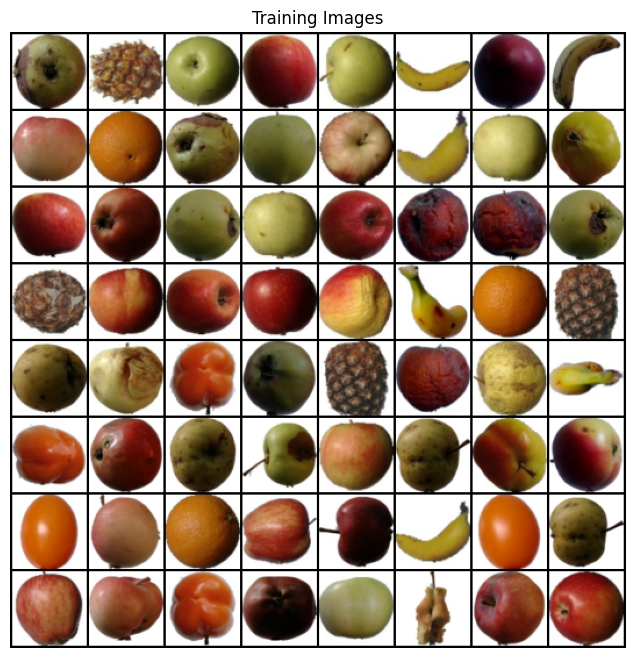

In [ ]:
import numpy as np

# Show a few samples
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

In [ ]:
# Define GAN architecture
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 3*64*64),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(z.size(0), 3, 64, 64)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3*64*64, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

latent_dim = 100
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)


In [ ]:
# GAN Training
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

epochs = 50

for epoch in range(epochs):
    for imgs, _ in dataloader:
        real_imgs = imgs.to(device)
        batch_size = imgs.size(0)

        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    if (epoch+1) % 10 == 0:
        print(f"[Epoch {epoch+1}/{epochs}] D loss: {d_loss.item():.4f}, G loss: {g_loss.item():.4f}")


[Epoch 10/50] D loss: 0.1892, G loss: 3.1797
[Epoch 20/50] D loss: 0.1456, G loss: 3.9717
[Epoch 30/50] D loss: 0.2357, G loss: 2.8446
[Epoch 40/50] D loss: 0.1506, G loss: 3.4362
[Epoch 50/50] D loss: 0.0288, G loss: 5.4674


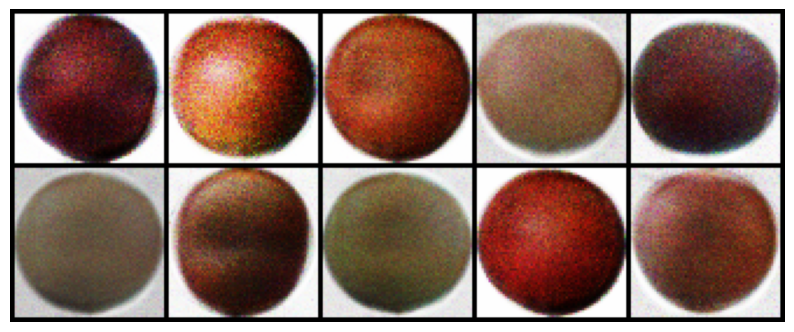

In [ ]:
#  Generate and visualize images
z = torch.randn(10, latent_dim, device=device)
gen_imgs = generator(z).cpu().detach()
gen_imgs = (gen_imgs + 1) / 2  # Denormalize

grid = make_grid(gen_imgs, nrow=5)
plt.figure(figsize=(10, 5))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()
